# Clustering de documents

In [5]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [6]:
from sklearn.datasets import make_blobs
import numpy as np


In [7]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
data_path = "../data/txt/"

In [9]:
# Choisir une décennie
DECADE = '1960'

In [10]:
# Charger tous les fichiers de la décennie et en créer une liste de textes
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [69]:
# Exemple de fichiers
files[:10]

['KB_JB838_1960-01-10_01-00018.txt',
 'KB_JB838_1960-01-12_01-00011.txt',
 'KB_JB838_1960-01-13_01-00009.txt',
 'KB_JB838_1960-01-21_01-00014.txt',
 'KB_JB838_1960-01-22_01-00015.txt',
 'KB_JB838_1960-01-27_01-00006.txt',
 'KB_JB838_1960-01-28_01-00011.txt',
 'KB_JB838_1960-01-28_01-00021.txt',
 'KB_JB838_1960-01-30_01-00007.txt',
 'KB_JB838_1960-01-31_01-00024.txt']

In [12]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [13]:
# Exemple de textes
texts[0][:500]

'ia« le som ÏJsIne MéuhMrïiqii S.AT\'BBirîï^^ J00, r. Merlu» Duché, Vllvorde ch. STENO-DACTYLO élément de let ordre, bilingue, bon- i ne rémunération. Situation d’avenir, i Candidat, A soumet par écrit 130221H PORTANTE 80C.BRUXELL0I8I cherche pour entrée Immédiate Secrétaire Sténo-Dactylo 3 françalee - 1 an d\'expérience, al tuât h «table - semaine de 5 Jours. Ecrire é cur. vit et prêt Ag. Rossel 02983 H "âociËTS\'Importante de sa pi* demande 1 Sténo-Dactylo bilingue débutante. - Se présenter : 151.'

#### Quelques statistiques au sujet de la decade choisie

In [70]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import numpy as np

In [71]:
count_decade = defaultdict(int)
count_month = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        decade = year[:3] + "0s"
        
        month = int(elems[2].split("-")[1])
        
        count_decade[decade] += 1
        count_newspapers[newspaper] += 1
        count_month[month] += 1
    else:
        print(f"Anomalous file: {f}")

In [72]:
# nombre de fichiers pour la décennie choisie
print(f"Il y a {count_decade['1960s']} fichiers pour la décennie 1960s")

Il y a 1000 fichiers pour la décennie 1960s


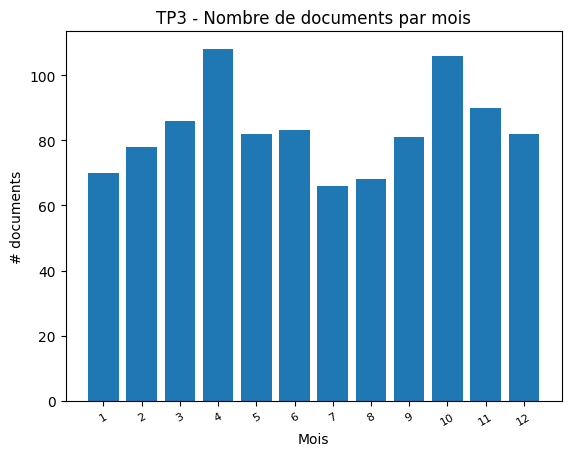

In [73]:
# Visualisation du nombre de document par mois
index = np.arange(len(count_month))
plt.bar(index, count_month.values())
plt.xlabel('Mois')
plt.ylabel('# documents')
plt.xticks(index, count_month.keys(), fontsize=8, rotation=30)
plt.title('TP3 - Nombre de documents par mois')
plt.show()

### Vectoriser les documents à l'aide de TF-IDF

In [14]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [15]:
# Instancier le modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [16]:
# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors = vectorizer.fit_transform(texts)

In [17]:
# Détail de la matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

In [18]:
# Imprimer le vecteur tf-IDF du premier documentpd.Series
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

rossel        0.429822
ecrire        0.290745
agence        0.287284
bilingue      0.195608
importante    0.172357
                ...   
er            0.000000
erreurs       0.000000
esp           0.000000
espagne       0.000000
♦             0.000000
Length: 2997, dtype: float64

### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

##### Trouver le nombre optimal de clusters (n_clusters) avec la méthode Elbow

In [61]:
X, y = make_blobs(n_samples=1000, n_features=2,random_state=0)
# Within-cluster Sum of Square (WSS)- somme des carrés intra-cluster
WSS = []
# Pour les valeur possible de 'k'
K = range(2, 10)
for n in K:
    algorithm = (KMeans(n_clusters = n) )
    algorithm.fit(X)
    WSS.append(algorithm.inertia_)

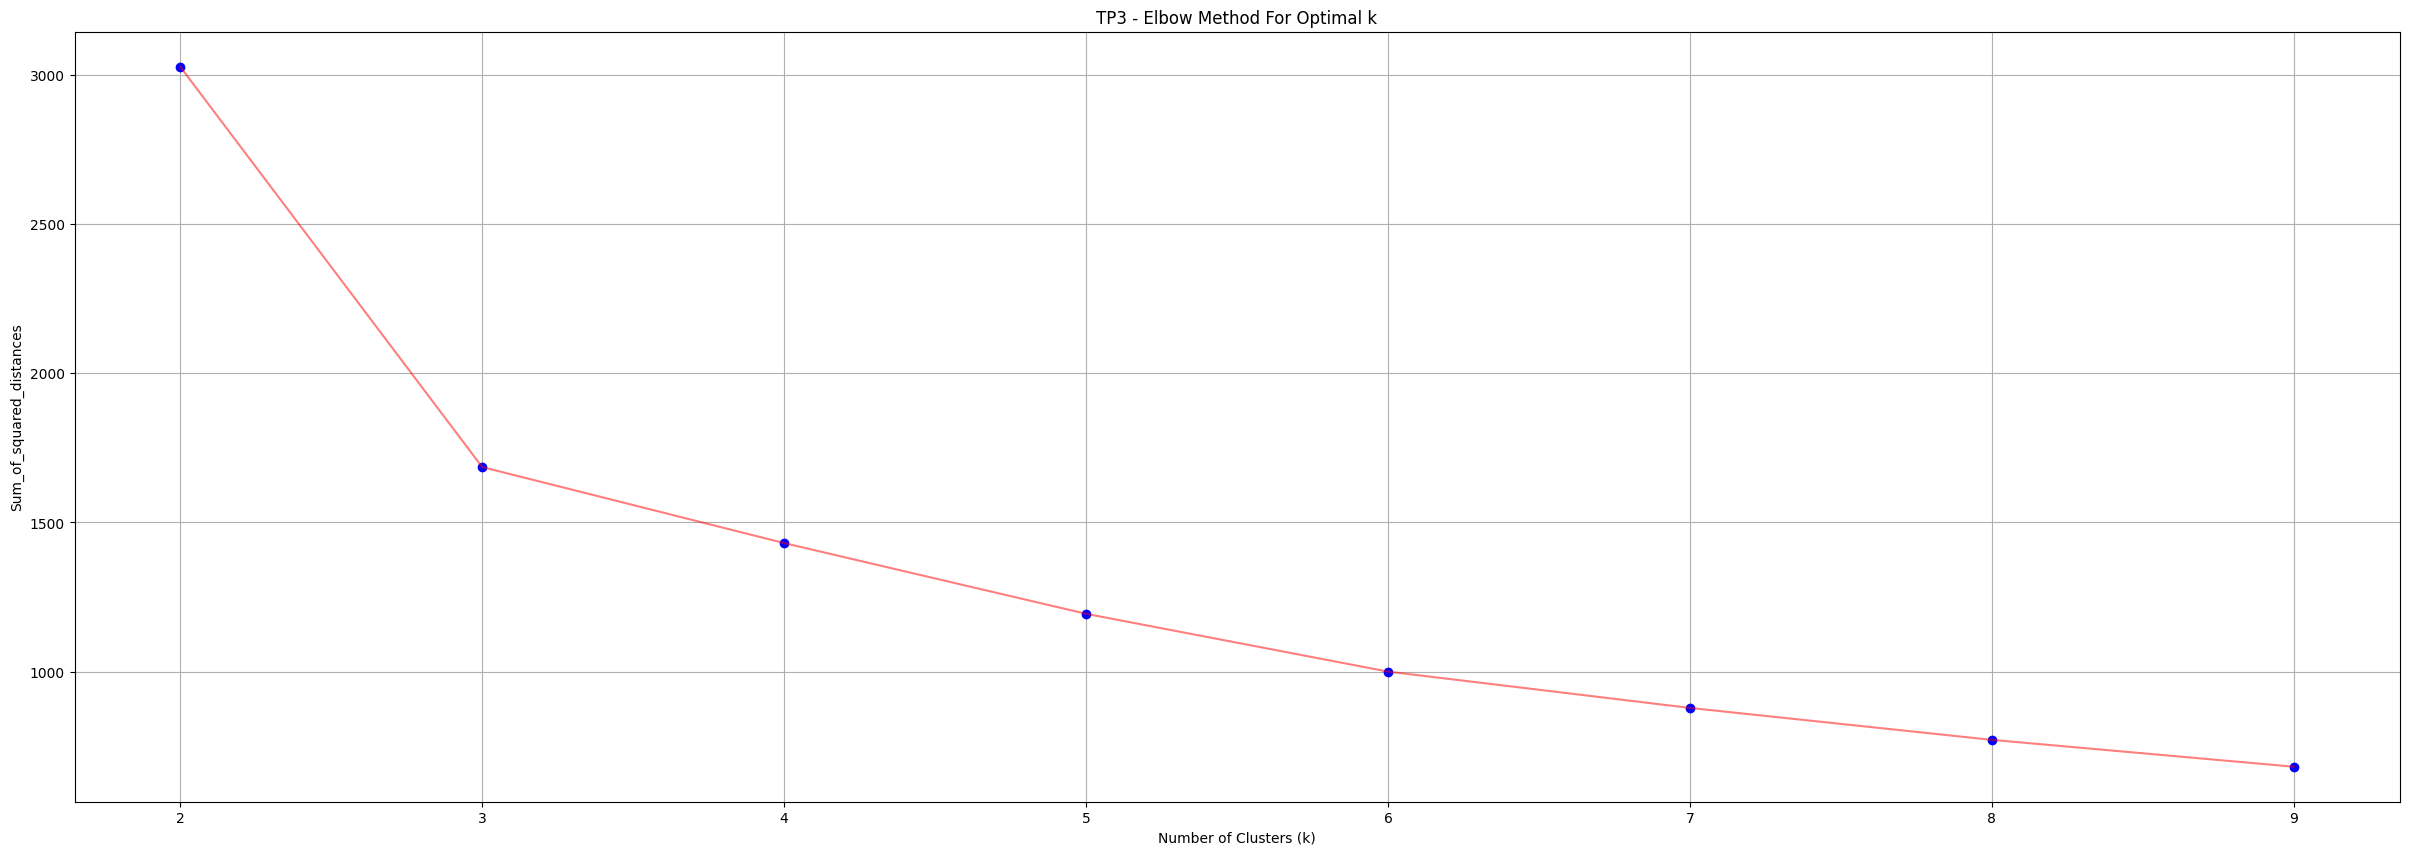

In [62]:
fig, (ax1) = plt.subplots(ncols =1)
# fig, (ax1) = plt.subplots(ncols =1)
fig.set_figheight(10)
fig.set_figwidth(30)

ax1.plot(K, WSS, 'bo')
ax1.plot(K, WSS, 'r-', alpha = 0.5)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Sum_of_squared_distances')
ax1.set_title('TP3 - Elbow Method For Optimal k')
ax1.grid(True)

In [22]:
# Définir un nombre de clusters
N_CLUSTERS = 3

In [25]:
# Instancier le modèle K-Means et ses arguments
km_model = KMeans(n_clusters=N_CLUSTERS)

In [26]:
# Appliquer le clustering à l'aide de la fonction `fit_predict`
clusters = km_model.fit_predict(tfidf_vectors)

In [27]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
pprint(dict(clustering))

### Visualiser les clusters

In [29]:
# Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [30]:
reduced_vectors[:10]

array([[ 0.49940242, -0.43947927],
       [-0.22882537,  0.00137827],
       [-0.27935513, -0.01591036],
       [ 0.28620178,  0.51679286],
       [ 0.30678364,  0.51829425],
       [-0.28971537, -0.09053804],
       [-0.04734945,  0.04053677],
       [-0.06057915,  0.11984363],
       [-0.22345179, -0.05226794],
       [-0.12138459,  0.07470408]])

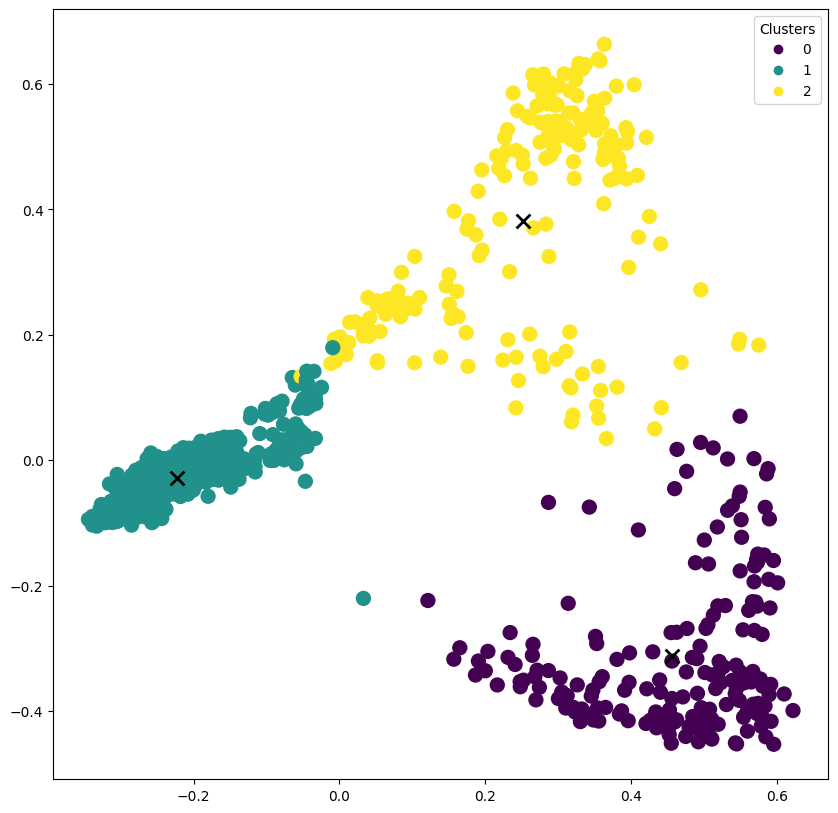

In [31]:
# Générer le plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings : le modèle Word2Vec

In [33]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

### Chargement et traitement des phrases du corpus

In [35]:
# Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [36]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

##### Détection des bigrams


In [37]:
bigram_phrases = Phrases(sentences)

In [38]:
type(bigram_phrases.vocab)

dict

In [39]:
len(bigram_phrases.vocab.keys())

15850647

In [40]:
# Conversion des `Phrases` en objet `Phraser`
bigram_phraser = Phraser(phrases_model=bigram_phrases)

##### Extraction des trigrams

In [41]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [42]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

##### Création d'un corpus d'unigrams, bigrams, trigrams

In [43]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [44]:
print(corpus[:100])

[['mi', 'imnri', 'r', 'i', '<<', 'i', 'i', 'hmu', "'", 'i', '/', 'tx', "-'", 'l', ':', 'marche', 'tenu', 'hors', 'villa', ',', 'la', '9', '.'], ['--', 'u', 'a', 'ete', 'vaain', 'si', 'teicj', '>>', 'm', 'races_indigenes', 'de', 'fr', '.'], ['31', '<)', 'a', '5s', "'", 'k', '131', 'de', '.'], ['rasa', 'iichakdui', "'", 'te', ',', 'do', '(', 'r', '.', '3s0', 'h', '710', '.', 'taureaux', 'iallsenas', ',>', 'ia', 'u', '\\', '--', 'a', '--', ';', '0ii', '.'], ['hollandais', ',', 'dufr', '.'], ['0', '.'], ['--', 'a', '9', '.--', 'la', 'idto', '-', 'vachei', 'laitieres', ':', 'bn', 'vante', '1q', '.'], ['vendues', '3', '\\', 'au', 'prix', 'la', '410', 'a', '*', '<<', 'i', 'h', '\\;', 'genisses', ',', 'kl', '.'], ["'.", '9', '.'], ['i', 'l', '.', '2', 'i', '.', 'id', '.'], ['da', '370', 'i', '6lutr', '.'], ['marche', 'a', '<', 'u', 'porcs', '.'], ['--', 'categorie', 'de', 'lt', 'ilashtya', ':', "'", '237', 'on', 'vente', ';', 'vendus', '1', 'm', '.', 'do', "'", '2', 'i', '.--', 'a', ';:,', 'l'

### Entrainement d'un modèle Word2Vec sur ce corpus

In [45]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=2, # La taille du "contexte", ici 2 mots avant et après le mot observé
    min_count=10, # On ignore les mots qui n'apparaissent pas au moins 10 fois dans le corpus
    workers=1, # Pas de parallelisation
    epochs=1 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 26min 21s
Wall time: 41min 24s


In [46]:
# Sauver le modèle dans un fichier
outfile = f"../data/newspapers.model"
model.save(outfile)

##### Explorer le modèle

In [47]:
# Charger le modèle en mémoire
model = Word2Vec.load("../data/newspapers.model")

In [48]:
# Imprimer le vecteur d'un terme
model.wv["directeur"]

array([-0.67578685, -1.8063583 ,  0.38112047,  1.04918   , -1.8882687 ,
       -1.2998881 , -3.0164258 , -0.4710169 , -1.5830549 ,  0.48804203,
        1.8379551 , -1.2415999 ,  1.637304  ,  0.9064664 , -0.9846686 ,
        1.6745278 ,  1.4728719 ,  0.33147672, -0.40552843, -0.82963884,
        0.15217873, -0.9777018 ,  3.3728027 , -0.5227684 ,  0.12490888,
        1.5850183 ,  0.9344785 ,  1.2369787 , -0.13618743, -4.8922124 ,
       -1.5528042 , -0.67665917], dtype=float32)

In [49]:
# Calculer la similarité entre deux termes: Exemple 1
model.wv.similarity("directeur", "doyen")

0.8996973

In [50]:
# Calculer la similarité entre deux termes: Exemple 2
model.wv.similarity("directeur", "eleve")

0.012841117

In [51]:
# Calculer la similarité entre deux termes: Exemple 3
model.wv.similarity("directeur", "directeur")

1.0

In [52]:
# Chercher les mots les plus proches d'un terme donné: Exemple 1
model.wv.most_similar("directeur", topn=5)

[('secretaire', 0.9204807877540588),
 ('directeur_general', 0.9079679250717163),
 ('membre', 0.9004807472229004),
 ('doyen', 0.8996972441673279),
 ('professeur', 0.8956307172775269)]

In [53]:
# Chercher les mots les plus proches d'un terme donné: Exemple 2
model.wv.most_similar("institut", topn=5)

[('academie', 0.8904618620872498),
 ('ecole', 0.8680539727210999),
 ('institut_national', 0.8586804270744324),
 ('association', 0.8432233333587646),
 ('office', 0.829876184463501)]

In [54]:
# Chercher les mots les plus proches d'un terme donné: Exemple 3
model.wv.most_similar("femme", topn=5)

[('jeune_femme', 0.8930578231811523),
 ('jeune_fille', 0.8865285515785217),
 ('fille', 0.8428325653076172),
 ('femmo', 0.8267726898193359),
 ('bile', 0.8217665553092957)]

##### Faire des recherches complexes à travers l'espace vectoriel

In [55]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme'], topn=1))

[('reine', 0.7927921414375305)]


In [56]:
print(model.wv.most_similar(positive=['lyon', 'belgique'], negative=['anvers'], topn=1))

[('france', 0.8610690832138062)]


In [58]:
print(model.wv.most_similar(positive=['liege', 'anvers'], negative=['belgique'], topn=10))

[('ath', 0.8340957164764404), ('etterbeek', 0.8246972560882568), ('evere', 0.813856840133667), ('enghien', 0.804882287979126), ('anderlecht', 0.8044556975364685), ('vilvorde', 0.7966938614845276), ('ixelles', 0.7956671118736267), ('ixeiles', 0.7878463864326477), ('ypres', 0.7858937382698059), ('forest', 0.7854872941970825)]
